# Object Detection

## First let's look at the dataset

## And try to visualize the bounding box

In [1]:
# my tool box for pytorch
from p3self.matchbox import *
from constant import *
from utils import *

In [2]:
%ls {IMG}|wc -l

118287


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
import numpy as np
import pandas as pd
import json
from glob import glob
from PIL import Image
import os

os.system("mkdir -p /data/bbsample")

0

#### Image table, with image url , image id, yup , that's all we need now

In [4]:
imgdf=pd.DataFrame(jsdict["images"])
imgdf.head()

,coco_url,date_captured,file_name,flickr_url,height,id,license,width
0,http://images.cocodataset.org/train2017/000000...,2013-11-14 11:18:45,000000391895.jpg,http://farm9.staticflickr.com/8186/8119368305_...,360,391895,3,640
1,http://images.cocodataset.org/train2017/000000...,2013-11-14 11:38:44,000000522418.jpg,http://farm1.staticflickr.com/1/127244861_ab0c...,480,522418,4,640
2,http://images.cocodataset.org/train2017/000000...,2013-11-14 12:36:29,000000184613.jpg,http://farm3.staticflickr.com/2169/2118578392_...,336,184613,3,500
3,http://images.cocodataset.org/train2017/000000...,2013-11-14 13:02:53,000000318219.jpg,http://farm5.staticflickr.com/4125/5094763076_...,640,318219,3,556
4,http://images.cocodataset.org/train2017/000000...,2013-11-14 16:03:19,000000554625.jpg,http://farm5.staticflickr.com/4086/5094162993_...,640,554625,3,426


#### An annotation table, in this case, we use "bbox"

In [5]:
ann_df=pd.DataFrame(jsdict["annotations"])
ann_df.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,2765.14865,"[199.84, 200.46, 77.71, 70.88]",58,156,558840,0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253...."
1,1545.42130,"[234.22, 317.11, 149.39, 38.55]",58,509,200365,0,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3..."
2,5607.66135,"[239.48, 347.87, 160.0, 57.81]",58,603,200365,0,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402...."
3,0.00000,"[296.65, 388.33, 1.03, 0.0]",58,918,200365,0,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388...."
4,800.41325,"[251.87, 333.42, 125.94, 22.71]",58,1072,200365,0,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335...."


#### A category table

In [6]:
len(idx2name)

80

In [7]:
urls = glob(IMG+"/*")

In [8]:
urls[:5]

['/terminus/coco/train2017/000000184383.jpg',
 '/terminus/coco/train2017/000000038938.jpg',
 '/terminus/coco/train2017/000000029019.jpg',
 '/terminus/coco/train2017/000000256529.jpg',
 '/terminus/coco/train2017/000000427301.jpg']

#### Get the image id from image url

In [9]:
rdimg = np.random.choice(urls)
def get_id(url):
    return int(url.split("/")[-1].split(".")[0])

#### Get the bounding box data from annotation

In [10]:
def get_bb(rdimg):
    match = ann_df[ann_df["image_id"]==get_id(rdimg)][["bbox","category_id"]]
    return list(match["bbox"]),list(match["category_id"])

In [11]:
get_bb(rdimg)

([[13.7, 97.5, 375.51, 486.51],
  [0.53, 0.0, 65.53, 190.99],
  [217.17, 401.26, 243.05, 155.32],
  [0.29, 188.75, 59.47, 74.34],
  [367.93, 116.31, 31.68, 55.98],
  [316.73, 62.24, 26.75, 33.97],
  [390.4, 57.95, 71.72, 42.29]],
 [16, 16, 51, 51, 16, 16, 16])

#### Picture boxes by loops into the picture

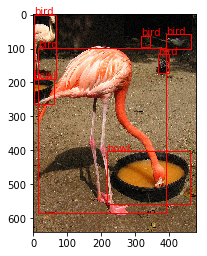

In [12]:
fig,ax = plt.subplots(1)
ax.imshow(Image.open(rdimg))
bbs,cids = get_bb(rdimg)
for i in range(len(bbs)):
    bb=bbs[i]
    # format of the bb: x, y, width, height
    rect = patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    # format of bb 
    ax.text(bb[0],bb[1],idx2name[cids[i]],dict({"color":"#ff0000"}))

In [13]:
fig.savefig("bbtest.png")

## You Only Look Once

### Introduction

From the paper [You Only Look Once: Unified, Real-Time Object Detection](http://arxiv.org/abs/1506.02640)

We divid the image to the grid boxes of size $S*S$

In each grid cell, we predict $B$ bounding boxes 

Each $B$ we have 5 predictions $x, y, w, h$ and confidence, 

$x,y$ relative to the grid box.$w, h$ relative to the entire picture.

Each grid cell, we predict class probability $Pr(Class_{i}|Object)$.

Then **class specified** confidence scores, when at test time we shall calculate, are:

$Pr(Class_{i}|Object)*Pr(Object)* IOU^{truth}_{pred}=Pr(Class_{i})* IOU^{truth}_{pred}$

IOU: **Intersection Over Union**

So the prediction are encoded in a tensor of size $S*S*(B*5+C)$

### YOLO style with anchor box

#### Get resized bb

In [14]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

In [15]:
def p_structure(md):
    """Print out the model structure"""
    for par in md.parameters():
        print(par.size())

def p_count(md):
    """count the parameters in side a pytorch module"""
    allp=0
    for p in md.parameters():allp+=np.product(p.data.numpy().shape)
    return allp

##### Random Try

In [16]:
cell_y=torch.arange(0,FEAT_W)

cell_y=cell_y.repeat(FEAT_H).view(1,FEAT_H,FEAT_W,1,1)

cell_x=cell_y.transpose(1,2)
#cell_x,cell_y
cell_grid=torch.cat([cell_x,cell_y],dim=-1)

#### Prepare bb data

In [17]:
def df_data(imgdf,ann_df,shuffle=True):
    """
    imgdf:
    A dataframe about images, fields: "id","file_name","height","width"
    ann_df:
    A dataframe about annotation, fields: "image_id","category_id","bbox",
    The field "bbox" is a list of 4 values: x,y,height, width of the bounding box
    """
    data_df=pd.merge(ann_df[["bbox","category_id","image_id"]],
                     imgdf[["id","file_name","height","width"]],
                     left_on="image_id",right_on="id")
    
    data_df["cate_id_oh"] = data_df["category_id"].apply(lambda x:idx2id[x])
    if shuffle:
        data_df = data_df.sample(frac=1).reset_index(drop=True)
    print("total data rows",len(data_df))
    return data_df

data_df = df_data(imgdf,ann_df)
data_df.head()

total data rows 860001


,bbox,category_id,image_id,id,file_name,height,width,cate_id_oh
0,"[382.92, 271.87, 179.97, 72.76]",1,322719,322719,000000322719.jpg,426,640,0
1,"[300.88, 273.43, 64.75, 38.03]",20,563009,563009,000000563009.jpg,480,640,18
2,"[257.0, 420.93, 55.35, 59.07]",47,224164,224164,000000224164.jpg,480,640,41
3,"[166.55, 203.86, 23.75, 11.12]",84,208121,208121,000000208121.jpg,480,640,73
4,"[99.93, 109.83, 11.85, 21.25]",44,317022,317022,000000317022.jpg,332,500,39


##### Resize the bounding box

In [18]:
bbox_array = np.array(data_df.bbox.tolist())
wh_array = data_df[["width","height"]].as_matrix()

def re_calibrate(bbox_array,wh_array):
    """return the resized bbox array"""
    bb_resized = (bbox_array/np.concatenate([wh_array,wh_array],axis=-1)) *SIZE
    
    true_bb = bb_resized/32
    # swith xy as left top conner to center point
    true_bb[...,:2]=true_bb[...,:2]+true_bb[...,2:]/2
    # Labels' Anchor positions on the grid map
    grid_bbxy = np.floor(true_bb[...,:2])
    return bb_resized,true_bb,grid_bbxy

bb_resized,true_bb,grid_bbxy = re_calibrate(bbox_array,wh_array)
true_bbxy,true_bbwh = true_bb[...,:2],true_bb[...,2:]

In [19]:
bb_resized

array([[248.898     , 265.48807512, 116.9805    ,  71.05201878],
       [195.572     , 236.97266667,  42.0875    ,  32.95933333],
       [167.05      , 364.806     ,  35.9775    ,  51.194     ],
       ...,
       [ 43.29      , 225.16866667,  88.595     ,  45.10133333],
       [164.528     , 137.592     ,  53.7745    , 163.19911111],
       [185.8935    , 180.83764706, 136.8575    , 172.84065882]])

In [20]:
def find_best_anchors(true_bbwh):
    iou_score = []
    for b in range(BOX):
        wh_anc = np.tile(ANC_ARR[b],[true_bbwh.shape[0],1])
        true_area = true_bbwh.prod(axis=-1)
        anc_area = wh_anc.prod(axis=-1)
    
        inter_area = np.min([wh_anc,true_bbwh],axis=0).prod(axis=-1)
    
        union_area = true_area + anc_area - inter_area
        iou_score.append(inter_area/union_area)
    best_anchor_idx = np.array(iou_score).T.argmax(axis=-1)
    return best_anchor_idx

best_anchor_idx = find_best_anchors(true_bbwh)

##### Index to onehot

In [21]:
cate_idx = data_df["cate_id_oh"].as_matrix()

cate_oh = np.eye(cate_idx.max()+1)[cate_idx]

In [22]:
true_vec = np.concatenate([true_bb,np.ones((true_bb.shape[0],1)),cate_oh],axis=-1)

#### Reverse adjust funtion to get train labels

* t to b

$\large b_{x}=\sigma(t_{x})+c_{x}$

$\large b_{y}=\sigma(t_{y})+c_{y}$

$\large b_{w}=p_{w}e^{w}$

$\large b_{h}=p_{h}e^{h}$

* b to t

$\large t_{x}=-ln(\frac{1}{b_{x}-c_{x}}-1)$

$\large t_{y}=-ln(\frac{1}{b_{y}-c_{y}}-1)$

$\large t_{w}=ln(\frac{b_{w}}{p_{w}})$

$\large t_{h}=ln(\frac{b_{h}}{p_{h}})$

In [23]:
from numpy import inf
true_adj = true_vec
# true_adj[true_adj == -inf] = 0

In [24]:
vec_loc = np.concatenate([grid_bbxy,np.expand_dims(best_anchor_idx,axis=-1)],axis=-1).astype(np.int)

#### Feature Extractor

In [25]:
from conv_model import dn121_conv

dn121=dn121_conv(DN121)

In [26]:
bce = nn.modules.loss.BCELoss()

In [27]:
class dn_yolo(nn.Module):
    def __init__(self,feat_extra,feat_in):
        super(dn_yolo,self).__init__()
        self.feat_in = feat_in
        self.feat_extra=feat_extra
        
        self.conv_1 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_2 = nn.Conv2d(self.feat_in,feat_in,kernel_size=(3,3),stride=(1,1),padding=1,bias=False)
        self.conv_3 = nn.Conv2d(self.feat_in,VEC_LEN*BOX,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(self.feat_in)
        self.bn2 = nn.BatchNorm2d(self.feat_in)
        self.bn3 = nn.BatchNorm2d(self.feat_in)
    
    def forward(self,x):
        
        x = self.feat_extra(x)
        
        x = self.bn1(x)
        x = self.conv_1(x)
        x = self.bn2(x)
        x = self.conv_2(x)
        x = self.bn3(x)
        x = self.conv_3(x)
        
        # from: bs,channel, height, width
        # to: bs, width, height, channel
        x = x.permute([0,3,2,1]).contiguous().view(-1,FEAT_W,FEAT_H,BOX,VEC_LEN)
        
        return x

### Data Generator

In [28]:
from torch.utils.data import DataLoader,dataset
from torchvision import transforms
from PIL import Image

In [29]:
transform = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],[.5,.5,.5])
                               ])
trans_origin = transforms.Compose([transforms.Resize((HEIGHT,WIDTH)),
                                transforms.ToTensor(),
                               ])
back2PIL = transforms.Compose([transforms.ToPILImage(mode="RGB")])

### Training

In [30]:
from torch.utils.data import DataLoader
from tqdm import trange
from datetime import datetime
import os
from p3self.matchbox import Trainer


In [31]:
from data import odData

train_set = odData(urllist = list(IMG+i for i in list(data_df["file_name"])),
                          true_adj = true_adj,
                          vec_loc = vec_loc[:,np.newaxis,:],
#                            true_vec = true_vec,
                          transform = transform,
                           trans_origin=trans_origin,
                  )

In [32]:
trainer=Trainer(train_set,batch_size=8,print_on=5)
model = dn_yolo(dn121,1024)
from loss_ import yolo3_loss_on_t as yolo3_loss
loss_func = yolo3_loss(lbd_noobj=.3,testing=False)

In [33]:
CUDA = torch.cuda.is_available()
if CUDA:
    torch.cuda.empty_cache()
    model.cuda()
    loss_func.cuda()

In [34]:
from torch.optim import Adam
optimizer = Adam(model.parameters())

In [ ]:
def action(*args,**kwargs):
    """
    y_s: label for scoring, because the y's bb has been transformed into t
    """
    x,y,imgs,lbl_mask,vec_loc,t_xy,t_wh = args[0]
    iteration=kwargs["ite"]
    x,y,lbl_mask,vec_loc,t_xy,t_wh = Variable(x),Variable(y),Variable(lbl_mask),Variable(vec_loc),Variable(t_xy),Variable(t_wh)
    if CUDA:
        x,y,lbl_mask,t_xy,t_wh=x.cuda(),y.cuda(),lbl_mask.cuda(),t_xy.cuda(),t_wh.cuda()
    optimizer.zero_grad()
    
    y_ = model(x)
    model.x=x
    model.y_=y_
    model.y=y
    
    loss,loss_x,loss_y,loss_w,loss_h,loss_obj,loss_noobj,loss_cls = loss_func(y_,y,lbl_mask,vec_loc,t_xy,t_wh)
    loss.backward()

    optimizer.step()
    
    if iteration%200==0:
        y_pred = loss_func.t2b(y_)[0]
        if CUDA:
            y_pred=y_pred.cpu()
        img=back2PIL(imgs[0])
        printimg=plot_bb(img,data_to_df(y_pred))
    return {"loss":loss.data[0],
            "loss_x":loss_x.data[0],
            "loss_y":loss_y.data[0],
            "loss_w":loss_w.data[0],
            "loss_h":loss_h.data[0],
            "loss_obj":loss_obj.data[0],
            "loss_noobj":loss_noobj.data[0],
            "loss_cls":loss_cls.data[0],}

trainer.action=action

In [ ]:
trainer.train(1)

⭐[ep_0_i_3889]	loss	29640.745✨	loss_cls	29620.819✨	loss_h	6.330✨	loss_noobj	0.031✨	loss_obj	3.949✨	loss_w	5.679✨	loss_x	2.069✨	loss_y	1.868:   4%|▎         | 3890/107501 [29:07<12:55:33,  2.23it/s]     

In [36]:
model.load_state_dict(torch.load("yolo_v3.0.0.1.pkl"))

In [37]:
torch.save(model.state_dict(),"yolo_v3.0.0.1.pkl")

## Debugging

In [38]:
train_set = odData(urllist = list(IMG+i for i in list(data_df["file_name"])),
                          true_adj = true_adj,
                          vec_loc = vec_loc[:,np.newaxis,:],
#                            true_vec = true_vec,
                          transform = transform,
                           trans_origin=trans_origin,
                           testing=True,
                  )

dl = iter(DataLoader(train_set,batch_size=12,shuffle=True))

a = next(dl)

b [[5.32522656 8.21275    3.84292188 8.60816667 1.        ]] 	txy [[-0.72985493 -1.30842809]] 	twh [[0.14073235 0.45263964]]
b [[11.93298438  6.63764706  0.2721875   1.22047059  1.        ]] 	txy [[2.63346265 0.56516622]] 	twh [[-0.74392323  0.58875199]]
b [[0.82225    8.92165625 0.897      0.94453125 1.        ]] 	txy [[1.53166642 2.46506613]] 	twh [[0.44864146 0.33244898]]
b [[5.54165625 6.84308962 0.24578125 0.19377358 1.        ]] 	txy [[0.16701213 1.68139847]] 	twh [[-0.84597249 -1.25154941]]
b [[4.82594531 6.89547753 0.70017187 1.8397191  1.        ]] 	txy [[1.55715902 2.14795504]] 	twh [[-0.98475006 -0.11432049]]
b [[4.09205469 7.93739837 0.61973438 2.05357724 1.        ]] 	txy [[-2.28880132  2.7063171 ]] 	twh [[-1.10678494 -0.00435012]]
b [[ 2.83582812 12.56910798  1.906125    0.86178404  1.        ]] 	txy [[1.6275091  0.27821267]] 	twh [[ 0.01675177 -0.87268396]]
b [[7.71742969 3.97987629 0.43448438 0.27983505 1.        ]] 	txy [[0.93174753 3.88552754]] 	twh [[-0.27625442 -0.8

In [40]:
a[0]


( 0 , 0 ,.,.) = 
  0.6784  0.6941  0.7255  ...   0.2627  0.2392  0.2863
  0.7098  0.7333  0.7569  ...   0.2549  0.2235  0.2157
  0.7412  0.7804  0.7961  ...   0.2706  0.2392  0.2314
           ...             ⋱             ...          
 -0.6549 -0.6471 -0.6392  ...  -0.5765 -0.5843 -0.5765
 -0.6471 -0.6392 -0.6392  ...  -0.5686 -0.5529 -0.5765
 -0.6392 -0.6392 -0.6471  ...  -0.5608 -0.5294 -0.5765

( 0 , 1 ,.,.) = 
  0.6784  0.6941  0.7333  ...   0.4275  0.4039  0.4353
  0.7098  0.7412  0.7647  ...   0.4196  0.3882  0.3804
  0.7412  0.7882  0.8039  ...   0.4431  0.4196  0.3961
           ...             ⋱             ...          
 -0.8196 -0.8118 -0.8039  ...  -0.7098 -0.7176 -0.7098
 -0.8118 -0.8039 -0.8039  ...  -0.7020 -0.6863 -0.7098
 -0.8039 -0.8039 -0.8118  ...  -0.6941 -0.6627 -0.7098

( 0 , 2 ,.,.) = 
  0.7412  0.7412  0.7725  ...   0.3647  0.3647  0.4196
  0.7725  0.7882  0.8039  ...   0.3647  0.3333  0.3412
  0.8039  0.8353  0.8431  ...   0.3569  0.3412  0.3255
           

In [ ]:
loss_func(model.y_,model.y)

In [36]:
y_true=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))
y_pred=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))

In [70]:
mask = loss_func.loss_mask(loss_func.t2b(model.y_),loss_func.t2b(model.y)).float()
y_=mask*model.y_.float()
y=mask*model.y.float()
a=F.binary_cross_entropy(F.sigmoid(model.y_[...,4].float()),model.y[...,4].float())


In [52]:
train_set

In [49]:
ulist = np.random.choice(trainer.dataset.urllist,500)
def RDIMG():return np.random.choice(ulist)
img=Image.open(RDIMG()).resize((416,416))

In [49]:
trainer=Trainer(train_set,batch_size=8,print_on=20)
model = dn_yolo(dn121,1024)
loss_func = yolo3_loss()

In [50]:
train_gen = iter(trainer.train_data)
train_sp = next(train_gen)

In [53]:
cnv=nn.Conv2d(3,25,kernel_size=3,padding=1)

In [54]:
b=cnv(Variable(torch.rand(32,3,10,10)))

In [55]:
b[:,:,7,:].sum()

Variable containing:
-208.6830
[torch.FloatTensor of size 1]

In [56]:
b.view(32,10,10,25)[:,7,:,:].sum()

Variable containing:
-776.7420
[torch.FloatTensor of size 1]

In [57]:
b.permute([0,2,3,1]).contiguous().view(32,10,10,5,5)[:,7,:,:,:].contiguous().sum()

Variable containing:
-208.6830
[torch.FloatTensor of size 1]